In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda


In [2]:
seed = 42  # TODO: set seed to allow for reproducibility of results

import os
os.environ['PYTHONHASHSEED'] = str(seed)

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import torch
torch.manual_seed(seed)

# initialize environment
from envs.environment_t import Environment 

from utils.helper_fcts import display_state

data_dir = os.path.join(os.path.abspath(''), 'data')
variant = 0  # TODO: specify problem variant (0 for base variant, 1 for first extension, 2 for second extension)
env = Environment(variant, data_dir)


In [3]:
import torch
from IPython.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger
from torch import Tensor, nn
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
import random
import pandas as pd
from copy import deepcopy
from itertools import compress, chain
from collections import namedtuple, deque
from itertools import count
import time 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import math

In [4]:
BATCH_SIZE = 64
GAMMA = 0.5
EPS_START = 0.999
EPS_END = 0.05
EPS_DECAY = 1e10
TAU = 0.005
LR = 1e-6


class DQN(nn.Module):
    '''Trying the simple network'''
    
    def __init__(self, obs_size:int, n_actions: int, hidden_size: int=256):
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, n_actions),
            )
        
    def forward(self, x):
        return self.net(x.float())

In [5]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))
# TODO: Here is probabl will give an issue regarding which information we can have 
# from the environment 

class ReplayMemory(object): 
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        '''Append to the buffer'''
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    


In [6]:
data_dir = os.path.join(os.path.abspath(""), "data")
env = Environment(0, data_dir)


In [7]:

# Get number of actions from gym action space
n_actions = 5
# Get the number of state observations
mode = "training"
state = env.reset(mode)
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
# Copy the main network to target network 
target_net.load_state_dict(policy_net.state_dict())

optimizer = Adam(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(200)

steps_done = 0


# Utils Scripts ( Visualization and WnB )
TODO: Move this into a util scripts for us to use 

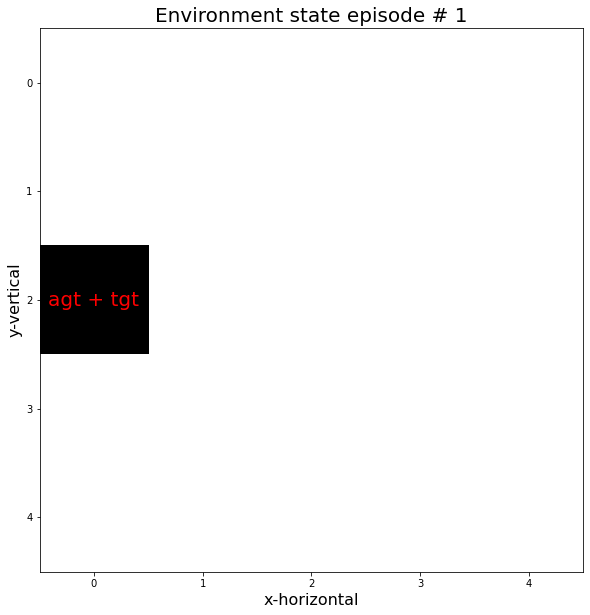

In [8]:
# TEST STATE
# state = np.zeros([5,5])
# state[0][2] = 3 # target
# state[3][4] = 1 # agent
# state[4][0] = 2 # item
# state[2][3] = 2 # item
# display_state(state=state, episode=1)

display_state(state=env.get_state(), episode=1)
# print(env.get_state())

#### Weight and biases setup

In [9]:
import wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="Warehouse Gridworld",
    
    # track hyperparameters and run metadata
    config={
    "architecture": "DQN",
    "learning_rate": LR,
    "batchsize": BATCH_SIZE,
    "gamma" : GAMMA,
    "tau" : TAU,
    "epsilon_start" : EPS_START,
    "epsilon_end": EPS_END,
    "epsilon_decay" : EPS_DECAY
    }
)


wandb: Currently logged in as: benoitauclair30 (drl_tum2023). Use `wandb login --relogin` to force relogin


TODO: Create a new class agent and put select_action in: 

In [10]:
def select_action(state):
    '''Action selection based on decay greedy
    TODO: we could also implement based on epsilon-greedy
    '''
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # print(f"{steps_done} step: threshol is {eps_threshold}")
    
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action_chosen = policy_net(state).max(1)[1].view(1, 1)
            return action_chosen
    else:
        action_space = range(5)
        action_chosen = torch.tensor([random.sample(action_space,1)], device=device, dtype=torch.long)
        return action_chosen



## Traning loop   

In [11]:
def optimize_model(): 
    if len(memory) < BATCH_SIZE: 
        return 
    
    # turn the transition to batch 
    transitions = memory.sample(BATCH_SIZE)
    # print(f" Sample Transition {transitions[15]}")
    batch = Transition(*zip(*transitions))
    # print(f" Batch for training {batch.action}")
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # --> get the output of the net using the state, where an action was taken
    # 
    
    # Comput Vs for all nextstate 
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad(): 
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    
    # Compute Huber Loss 
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model 
    optimizer.zero_grad()
    loss.backward()
    
    # Inplace gradient clipping 
    # torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    

In [12]:
if torch.cuda.is_available():
    num_episodes = 5000
else: 
    num_episodes = 50
    
cummulative_reward = []
from tqdm import tqdm
# display_state(state=env.get_state(), episode=1)

print(f'Training Start, running on {device}')

pbar = tqdm(total=num_episodes)
for i_expisode in range(num_episodes):
    # Run Validation Reward
    if i_expisode % 100 == 0 : 
        val_rew = 0 
        state = env.reset("training")
        state = torch.tensor(state, dtype=torch.float32, device = device).unsqueeze(0)
        for j in range(200):  # loop over 200 steps per episode
            act = select_action(state)  # TODO: get action for the obs from your trained policy
            rew, next_obs, _ = env.step(act)  # take one step in the environment
            val_rew += rew  # track rewards
            obs = next_obs  # continue from the new obs
        wandb.log({
            "val_reward": val_rew
        })    
        pbar.write(f'Episode {i_expisode} / {num_episodes}, validation reward: {val_rew}')

    state = env.reset(mode)
    state = torch.tensor(state, dtype=torch.float32, device = device).unsqueeze(0)
    
    for t in count():
        action = select_action(state)
        reward, observation, done = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        if done: 
            next_state = None
        else: 
            # visualization
            # clear_output(wait=True)
            # display_state(state=env.get_state(), episode=i_expisode)
            # time.sleep(0.4)
            
            next_state = torch.tensor(observation, dtype=torch.float32,device=device).unsqueeze(0)
    
        # store in memory 
        memory.push(state, action, next_state, reward)

        state = next_state
        
        optimize_model()
        
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU \
                + target_net_state_dict[key]*(1-TAU)
                
        target_net.load_state_dict(target_net_state_dict)
        
        if done: 
            cummulative_reward.append(reward)
            break
    pbar.update(1)    

print('complete')

Training Start, running on cuda


  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Episode 0 / 5000, validation reward: -106.5


  0%|                                         | 12/5000 [00:10<59:56,  1.39it/s]

KeyboardInterrupt: 

### Play the game with the final state

In [ ]:
state = env.reset("training")
state = torch.tensor(state, dtype=torch.float32, device = device).unsqueeze(0)

for j in range(200):  # loop over 200 steps per episode
  
    act = select_action(state)  # TODO: get action for the obs from your trained policy
    rew, next_obs, _ = env.step(act)  # take one step in the environment
    # visualization
    clear_output(wait=True)
    display_state(state=env.get_state(), episode=i_expisode)
    time.sleep(0.2)
    
    